# Playing with PyTorch Gradients

**GPU**
- N = 1,000 & p = 1,000,000 || Runtime = 15s

**CPU**
- N = 1,000 & p = 1,000,000 || Runtime = 5m29

In [1]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from tqdm.auto import trange

import matplotlib.pyplot as graph
graph.style.use('fivethirtyeight')
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"
if device == "cuda":
    torch.set_default_dtype(torch.float16)  # halfs our memory usage
print(f'Device is {device}')

Device is cpu


In [2]:
# Toy data
n, p = int(1e3), int(1e6)

true_beta = torch.zeros(p)
true_beta[:4] = torch.tensor([2.0, -2.0, 2.0, 3.0])
print(true_beta)

x = torch.randn(n, p)
y = x @ true_beta + 2.5 * torch.randn(n)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

print(x.shape, y.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

tensor([ 2., -2.,  2.,  ...,  0.,  0.,  0.])
torch.Size([1000, 1000000]) torch.Size([1000])
torch.Size([900, 1000000]) torch.Size([900])
torch.Size([100, 1000000]) torch.Size([100])


  0%|          | 0/1000 [00:00<?, ?it/s]

Parameter containing:
tensor([ 1.6620, -1.7095,  1.7882,  ...,  0.0000,  0.0000,  0.0000],
       requires_grad=True)


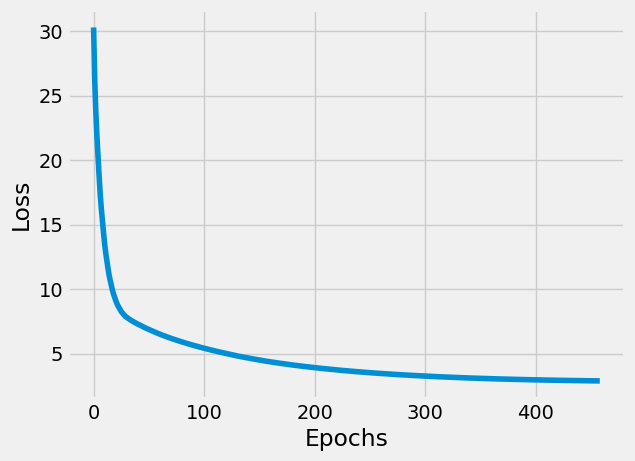

In [3]:
class Lasso(nn.Module):
    def __init__(self, p, lam=0.1, eps=1e-3):
        super().__init__()
        self.m = nn.Parameter(torch.zeros(p))
        self.b = nn.Parameter(torch.zeros(1))
        self.lam = lam
        self.eps = eps

        self.hist = []

    def forward(self, x):
        return x @ self.m + self.b

    def calc_loss(self, y_pred, y_true):
        # MSE + lam*||m||_1
        return torch.mean((y_pred - y_true) ** 2) + self.lam * torch.sum(torch.abs(self.m))

    def fit(self, x, y, epochs=1000, lr=0.1):
        self.hist = []
        self.b = nn.Parameter(torch.mean(y))

        iterator = trange(epochs)
        for _ in iterator:
            # Zero gradients
            self.zero_grad()

            # Forward pass
            y_hat = self.forward(x)

            # Backward pass
            loss = self.calc_loss(y_hat, y)
            iterator.set_description(f"Loss: {loss.item():.4f}")

            if len(self.hist) > 0 and abs(self.hist[-1] - loss.item()) < self.eps:
                break

            loss.backward()
            with torch.no_grad():
                m_grad_argmax = torch.argmax(torch.abs(self.m.grad))
                m_max_grad = self.m.grad[m_grad_argmax]
                m_new = torch.zeros_like(self.m.grad)
                m_new[m_grad_argmax] = m_max_grad
                m_new *= -lr

                # Update parameters
                self.m += m_new
                self.hist.append(loss.item())

        # Polishing step
        with torch.no_grad():
            self.m[torch.abs(self.m) < self.lam] = 0.0

model = Lasso(p).to(device)
model.fit(x_train.to(device), y_train.to(device))
print(model.m)

graph.plot(model.hist)
graph.xlabel("Epochs")
graph.ylabel("Loss")
graph.show()

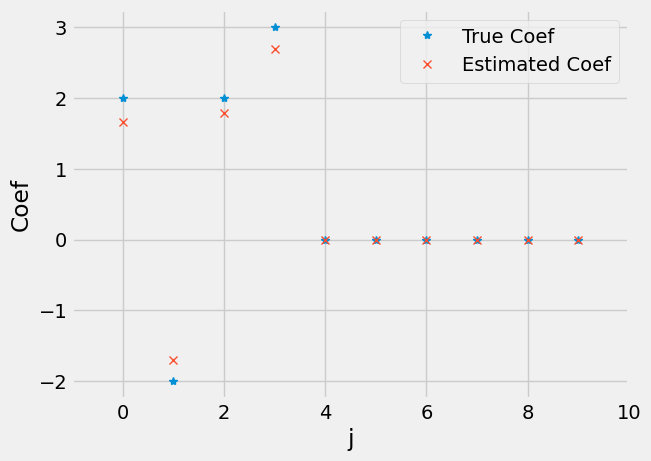

In [4]:
graph.plot(true_beta[:10], '*', linewidth=2, label='True Coef')
graph.plot(model.m[:10].detach().cpu(), 'x', linewidth=2, label='Estimated Coef')
graph.ylabel('Coef')
graph.xlabel('j')
graph.legend()
graph.xlim([-1, 10])
graph.show()